# Delta Y vs G - I, loop on airmass

- Focus on PWV

- author : Sylvie Dagoret
- affiliation : LAL/IN2P3/CNRS
- creation date : October 15th 2018
- update : October 22th 2018



In [42]:
import pandas as pd
import numpy as np
import os,sys
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from astropy.io import fits
%matplotlib inline
from scipy.interpolate import interp1d

In [43]:
from astropy.io import fits

In [44]:
from lsst.sims.photUtils import SignalToNoise
from lsst.sims.photUtils import PhotometricParameters
from lsst.sims.photUtils import Bandpass,Sed

In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

In [47]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (14, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [48]:
PATH_LIBRADTRAN='./librandtran'
PATH_MODTRAN='./modtran'
PATH_MYLSSTSIMS='./lsst_sims'

In [49]:
sys.path.append(PATH_LIBRADTRAN)
sys.path.append(PATH_MODTRAN)
sys.path.append(PATH_MYLSSTSIMS)

In [50]:
import libReadModtran as mt
import libsimulateTranspLSSTScattAbsAer3 as rt

In [51]:
from MyTelescope import *
from MyThroughputs import *

In [52]:
def plot_sedimg(data,index_spec):
    plt.figure(figsize=(15,10))   
    img=plt.imshow(data[1:,index_spec:],origin='lower',cmap='jet')
    plt.colorbar(img)
    plt.grid(True)
    plt.title('sed grid')
    plt.xlabel('bin number of wavelengths')
    plt.ylabel('sed number')
    plt.show()

In [53]:
def plot_allsed(data,index_spec):
    plt.figure()   
    
    for idx in np.arange(data.shape[0]-1):
      
        plt.semilogy(data[0,index_spec:],data[1+idx,index_spec:],'-')
    plt.grid(True)
    plt.title('sed')
    plt.xlabel('wavelength (A)')
    plt.ylabel('sed (flam)')
    plt.show()

# Config

In [54]:
#------------------------------------------------------------------------
# Definition of data format for the atmospheric grid
#-----------------------------------------------------------------------------
WLMIN=250.  # Minimum wavelength : PySynPhot works with Angstrom
WLMAX=1151. # Minimum wavelength : PySynPhot works with Angstrom
WL=np.arange(WLMIN,WLMAX,1) # Array of wavelength in Angstrom
NBWL=len(WL)


In [55]:
## Config LSST

In [56]:
all_filternum = {'u':1, 'g':2, 'r':3, 'i':4, 'z':5, 'y':6}

In [57]:
LSST_SkyBrightness=np.array([22.03,21.68,21.02,19.7,17.83,17.21])

In [58]:
LSST_GeomSeeing=np.array([1.1,1.02,0.95,0.92,0.88,0.94])

# Configuration of input SED

In [59]:
sed_file="regenerated_sedgrid_pickle_uvk.fits"

In [60]:
sed_hdu = fits.open(sed_file)

In [61]:
theheader=sed_hdu[0].header
theheader

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 8515                                                  
NAXIS2  =                12963                                                  
NBSED   =                12962                                                  
NBWLBIN =                 8510                                                  
WLMIN   =               3000.0                                                  
WLMAX   =              11510.0                                                  
WLBINWDT=                  1.0                                                  
SEDUNIT = 'FLAM    '                                                            
SEDMODEL= 'pickle_uvk'                                                          
IDX_NUM =                   

In [62]:
sidx_num=theheader['IDX_NUM']
sidx_val=theheader['IDX_VAL']
sidx_sed=theheader['IDX_SED']
sidx_data=theheader['IDX_DATA']
sidx_spec=theheader['IDX_SPEC']

In [63]:
sed_data=sed_hdu[0].data

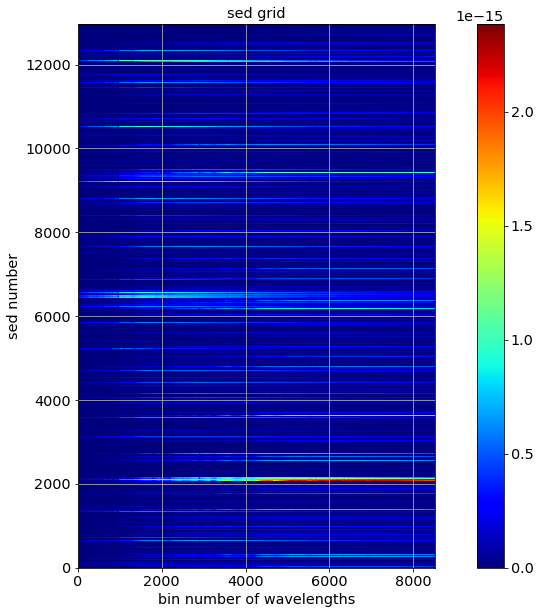

In [64]:
plot_sedimg(sed_data,sidx_spec)

In [65]:
#plot_allsed(sed_data,sidx_spec)

In [66]:
NBSED_MAX=sed_data.shape[0]-1

In [67]:
NBSED_MAX

12962

## Config for Modtran

In [68]:
path_modtrandata='modtrandata/Jul6th2018'

In [69]:
def GetModtranFilenames():
    files_data = [f for f in listdir(path_modtrandata) if isfile(join(path_modtrandata, f))]
    files_data.sort()
    
    # select reduced files
    files_selected=[]
    for file in files_data:
        if file.find("_reduced")==-1:
            print("reject ",file)
        else:
            files_selected.append(file)
            
    files_selected.sort()
    return files_selected


In [70]:
def GetAirmassFromModtranFilename(filename):
    splitted_filename=filename.split('.')
    tagname=splitted_filename[1]
    airmass_str=tagname.split('_')[0]
    am=float(airmass_str)/10.
    return am
    

In [71]:
files_modtran=GetModtranFilenames()

reject  Pachon_MODTRAN.10.7sc
reject  Pachon_MODTRAN.11.7sc
reject  Pachon_MODTRAN.12.7sc
reject  Pachon_MODTRAN.13.7sc
reject  Pachon_MODTRAN.14.7sc
reject  Pachon_MODTRAN.15.txt
reject  Pachon_MODTRAN.16.7sc
reject  Pachon_MODTRAN.17.7sc
reject  Pachon_MODTRAN.18.7sc
reject  Pachon_MODTRAN.19.7sc
reject  Pachon_MODTRAN.20.7sc
reject  Pachon_MODTRAN.21.7sc
reject  Pachon_MODTRAN.22.7sc
reject  Pachon_MODTRAN.23.7sc
reject  Pachon_MODTRAN.25.7sc
reject  Pachon_MODTRAN.7sc


In [72]:
NBMTFILES=len(files_modtran)-1

### Get all all available Modtran Airmasss

In [73]:
all_airmasses=[GetAirmassFromModtranFilename(files_modtran[idx]) for idx in np.arange(NBMTFILES) ]

In [74]:
all_airmasses

[1.0, 1.1, 1.2, 1.3, 1.4, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.5]

### Read all Modtran Data

In [75]:
all_mtdata=[]
for file in files_modtran:
    fullfilename=os.path.join(path_modtrandata,file)
    read_modtrandata=mt.loadtape7(fullfilename, colspec = ['WAVELENGTH_NM','COMBIN_TRANS'])
    all_mtdata.append(read_modtrandata)

### View all Modtran Data

In [76]:
jet = cm = plt.get_cmap('jet')
cNorm  = colors.Normalize(vmin=0, vmax=NBMTFILES)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

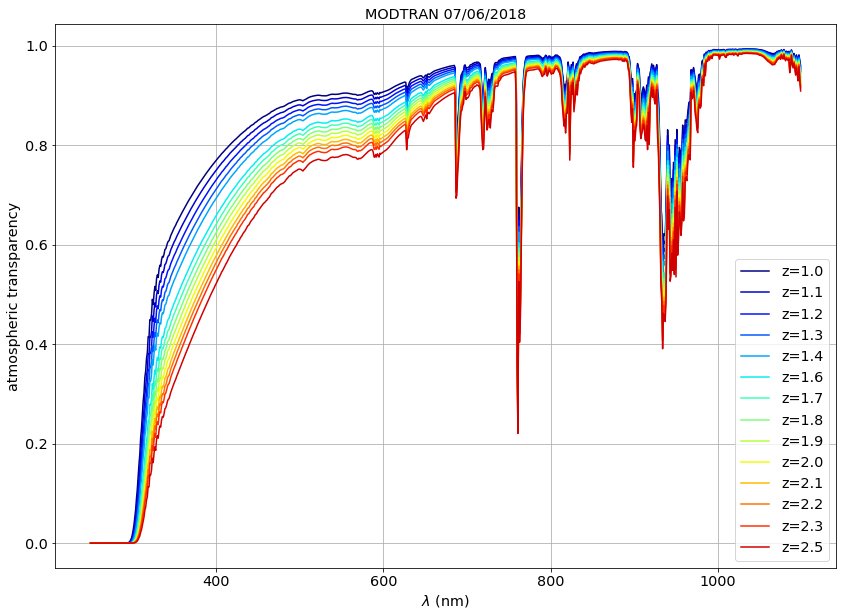

In [77]:
for idx in np.arange(NBMTFILES):    
    colorVal = scalarMap.to_rgba(idx)
    thelabel="z={:2.1f}".format(all_airmasses[idx])
    plt.plot(all_mtdata[idx][:,0],all_mtdata[idx][:,1],color=colorVal,label=thelabel)
plt.grid(True)
plt.title("MODTRAN 07/06/2018")
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("atmospheric transparency")
plt.legend(loc='best')

In [78]:
all_airmasses

[1.0, 1.1, 1.2, 1.3, 1.4, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.5]

# LOOP ON AIRMASS

In [85]:
filter_tag='y'
MAGCUT=17
NBSED_SEL=NBSED_MAX

In [82]:
def ComputeDeltaMagAndErrorMagAndColor(filter_tag,tel_rt,tel_mt,sed_data):
    
    
    filternum=all_filternum[filter_tag]-1
    skybrightness=LSST_SkyBrightness[filternum]
    FWHMgeom=LSST_GeomSeeing[filternum]
    
    
    # book collections
    all_pulls=np.zeros(NBSED_SEL)
    all_magdelta=np.zeros(NBSED_SEL)
    all_magerr=np.zeros(NBSED_SEL)
    all_color=np.zeros(NBSED_SEL)
    all_abmag=np.zeros(NBSED_SEL)
    
    #print("NBSED_SEL={}".format(NBSED_SEL))
    
    #loop on SED
    for idx_sed in np.arange(NBSED_SEL):
        # extract sed wl and flux
        picklesname='pickles_uvk_{}'.format(idx_sed+1)
        wl_sed=sed_data[0,sidx_spec:]/10.
        flux_sed=sed_data[idx_sed+1,sidx_spec:]*10.
        
        # fill Telescope with that SED
        tel_rt.Set_SED(wavel=wl_sed,newsed=flux_sed,name=picklesname)
        tel_mt.Set_SED(wavel=wl_sed,newsed=flux_sed,name=picklesname)
        
        #compute Instrumental Magnitude
        mag_adu_mt=tel_mt.CalcMyADUMagnitude_filter(filter_tag)
        mag_adu_rt=tel_rt.CalcMyADUMagnitude_filter(filter_tag)
        mag_ab=tel_rt.CalcMyABMagnitude_filter(filter_tag)
        m_g=tel_rt.CalcMyADUMagnitude_filter('g')
        m_i=tel_rt.CalcMyADUMagnitude_filter('i')
        color=m_g-m_i
        
        # compute magnitude error and delta mag
        mag_error=tel_rt.CalcMyABMagnitudesError_filter(filter_tag,skybrightness,FWHMgeom)
        delta_mag= mag_adu_mt-mag_adu_rt
    
        #print('\Delta M = {} \delta m = {} '.format(delta_mag,mag_error))
        
        #fill collection
        all_pulls[idx_sed]=delta_mag/mag_error
        all_magdelta[idx_sed]=delta_mag
        all_magerr[idx_sed]=mag_error
        all_color[idx_sed]=color
        all_abmag[idx_sed]=mag_ab
        
        
        #plt.semilogy(wl_sed,flux_sed)

    return all_magdelta,all_magerr,all_pulls,all_color,all_abmag
        

In [86]:
# LOOP
for idx_am_sel in np.arange(len(all_airmasses)):
    print(idx_am_sel)
    am=all_airmasses[idx_am_sel]
    mtdata_sel=all_mtdata[idx_am_sel]
    
    #transmission in libradtran
    wl0=mtdata_sel[:,0]
    tr0=mtdata_sel[:,1]
    
    wl=np.copy(WL)
    tr=np.ones(NBWL)

    wl[:len(wl0)]=wl0[:]
    tr[:len(tr0)]=tr0[:]
    
    new_wl_indexes=np.where(np.logical_and(wl>=300,wl<1050))
    
    new_wl=wl[new_wl_indexes]
    new_tr=tr[new_wl_indexes]
    
    # Modtran telescope
    tel_mt=Telescope()
    tel_mt.Set_Atmosphere(am,wl,tr)
    
    
    # Simulate libradtran atmosphere
    pressure = 782.5
    pwv=4.947
    aer=0
    ozone=300.
    wl0=500.
    all_pwv=np.array([pwv])
    NBRTFILES=len(all_pwv)
    
    all_rtdata=[]
    for pwv in all_pwv:
        path,thefile=rt.ProcessSimulationaer(am,pwv,ozone,wl0,aer)
        #path,thefile=rt.ProcessSimulation(am,pwv,ozone)
        data = np.loadtxt(os.path.join(path,thefile))
        all_rtdata.append(data)
        
        
    #libradtran telescope
    idx_pwv_sel=0
    rtdata_sel=all_rtdata[idx_pwv_sel]
    tel_rt=Telescope()
    tel_rt.Set_Atmosphere(am,rtdata_sel[:,0],rtdata_sel[:,1])
    
    # compute the Deltamag vs color
    all_magdelta,all_magerr,all_pulls,all_colors,all_abmag=ComputeDeltaMagAndErrorMagAndColor(filter_tag,tel_rt,tel_mt,sed_data)
    
    #select with small magnitude error
    selmag_index=np.where(all_abmag<MAGCUT)
    
    all_magdelta2=all_magdelta[selmag_index]
    all_colors2=all_colors[selmag_index]
    all_magerr2=all_magerr[selmag_index]
    all_abmag2=all_abmag[selmag_index]
    
    
    # save file
    airmass_num=int(10*am)
    am_str=str(airmass_num)
    airmass_str=am_str.zfill(2)
    
    filename_out="dataout_DeltaYvsGmI_z{}.txt".format(airmass_str)
    theheader="Delta Y vs color at airmass z= {} Ymag-cut = {} \n".format(am,MAGCUT)
    theheader+="color : deltamag : errmag "
    
    data_out=np.zeros((len(all_colors2),3))
    
    data_out[:,0]=np.copy(all_colors2)
    data_out[:,1]=np.copy(all_magdelta2)
    data_out[:,2]=np.copy(all_magerr2)
    
    np.savetxt(filename_out,data_out,fmt='%3.8f',header=theheader)
    
    

0
**** Throughputs.__init__****
System loaded from /sps/lsst/software/lsst_sims/sims_2_7_0/stack/miniconda3-4.3.21-10a4fa6/Linux64/throughputs/2017.01.31-6-g29ce4f5/baseline/
**** Telescope.__init__******
--------------------------------------------
 1) airmass =  1.0
 2) pwv =  4.947
 3) oz =  300.0
 4) wl0 =  500.0
 5) tau0 =  0
--------------------------------------------
Running uvspec with input file:  /scratch/dagoret/simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv49_oz30_aer0.INP
Output to file                :  /scratch/dagoret/simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv49_oz30_aer0.OUT
uvspec cmd:  /pbs/throng/lsst/users/dagoret/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < /scratch/dagoret/simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv49_oz30_aer0.INP > /scratch/dagoret/simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv49_oz30_aer0.OUT
**** Throughputs.__init__****
System loaded from /sps/lsst/software/l